# Homework 2 Part 2 - Model Based Reinforcement Learning

***

Written by Albert Wilcox

In this homework, you'll implement [PETS](https://arxiv.org/abs/1805.12114), a popular model for simple MBRL tasks.


In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import einops

import gym
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm, trange

from typing import Tuple, Optional

from src.utils import (
    get_device,
    set_seed,
    demo_policy,
    save_frames_as_gif
)
# Do not remove the following import
import src.cartpole_env
from src.mpc import MPC
from src.mbrl_utils import sample_rollout
from src.cartpole_env import CartpoleConfigModule
from src.mbrl_sampler import MBRLSampler

plt.ion()

/home/atharva/miniconda3/envs/drl/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/atharva/miniconda3/envs/drl/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
SEED: int = 42
ENVIRONMENT_NAME: str='MBRLCartpole-v0'

# torch related defaults
DEVICE = get_device()
torch.set_default_dtype(torch.float32)

# Use random seeds for reproducibility
set_seed(SEED)

2024-11-11 21:49:10.921 | INFO     | src.utils:get_device:52 - Using cuda device.
2024-11-11 21:49:10.923 | INFO     | src.utils:set_seed:38 - Random seed set as 42.


As before, we start by initializing the environment and printing some useful information.

In [3]:
env = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
action_dimension = env.action_space.shape[0]
state_dimension = env.observation_space.shape[0]

logger.info(f'Action Dimension: {action_dimension}')
logger.info(f'Action High: {env.action_space.high}')
logger.info(f'Action Low: {env.action_space.low}')
logger.info(f'State Dimension: {state_dimension}')

2024-11-11 21:49:13.469 | INFO     | __main__:<module>:7 - Action Dimension: 1
2024-11-11 21:49:13.470 | INFO     | __main__:<module>:8 - Action High: [3.]
2024-11-11 21:49:13.470 | INFO     | __main__:<module>:9 - Action Low: [-3.]
2024-11-11 21:49:13.470 | INFO     | __main__:<module>:10 - State Dimension: 4


### Part 1 - PETS

In this part you'll implement the PETS (Chua et al.) dynamics model and use it for model-based control (MPC). There are several important components of this pipeline:
 * The dynamics model, discussed in more detail in Chua et al, learns to predict the next state $s_{t+1}$ conditioned on the current state-action pair $(s_t, a_t)$.
 * The cost function outputs the cost of a planned state. In the case of this environment, we provide a ground truth cost function (negative velocity), but in more complicated environments where no ground truth cost function is available it is common to learn it.
 * Cross entropy method (CEM) is a gradient-free evolutionary optimizer. We use it to optimize sequences of actions, and evaluate these sequences of actions by predicting future states after rolling out the planned actions and computing the total cost of the predicted rollout under the cost function.

The first step is to set up our probabilistic dynamics model. As described in Chua et al, this should take in a state and action and output `mean` and `log_std` for a Gaussian distribution over possible future states.

In [4]:
from src.networks import network

class DynamicsModel(nn.Module):
    def __init__(self, 
                 state_dimension: int, 
                 action_dimension: int,
                 min_log_std: float = -5,
                 max_log_std: float = 1,
                 ):
        super(DynamicsModel, self).__init__()
        
        self.min_log_std = min_log_std
        self.max_log_std = max_log_std
        
        # Network outputs mean and log_std for next state distribution
        self.network = network(
            in_dimension=state_dimension + action_dimension,
            out_dimension=2 * state_dimension,
            n_hidden=2
        )
    
    def forward(self, state: torch.Tensor, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the dynamics network. Should return mean and log_std of the next state distribution

        Args:
            state (torch.Tensor): The input state.
            action (torch.Tensor): The input action.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The tuple (mean, log_std) of the distribution
        """
        x = torch.cat([state, action], dim=-1)
        out = self.network(x)
        mean, log_std = torch.split(out, state.shape[-1], dim=-1)
        log_std = torch.clamp(log_std, self.min_log_std, self.max_log_std)

        return mean, log_std

2024-11-11 21:49:17.834 | INFO     | src.utils:get_device:52 - Using cuda device.


The next step is to create an ensemble of dynamics models. There are better ways to implement this, but for the purposes of this assignment we'll simply maintain a list of models and loop through them at inference time. If you have access to a GPU and are interested in speeding up your implementation, you might want to check out https://pytorch.org/tutorials/intermediate/ensembling.html.

There are several ways to handle data for ensembles, such as partitioning the dataset or training each network on different minibatches from the same dataset. In this assignment, we randomly sample `n_ensemble` subsets of the data with replacement. For each epoch, we train each member of the ensemble on a different subset and then shuffle the subsets. To better understand this, please refer to `src/mbrl_sampler.py`.

TODOs for this section:
 * Fill in the `forward` function of the dynamics model to predict the mean and log_std from each member of the ensemble for a single batch of states and actions. This is for use during training
 * Fill in the `compute_cost` function which takes in a single state and a batch of action trajectory candidates and computes the expected cost for each one by rolling out the dynamics model. You should do this using the TS-1 algorithm from Chua et al, meaning for each step you randomly sample a dynamics model from the ensemble. Note the parameter `n_particles`. For each action trajectory candidate, you should sample `n_particles` trajectories and compute the mean between their costs.
 * Note: the `compute_cost` function will involve creating some large tensors. For tensors with many dimensions to keep track of, I would highly recommend using the `einops` library for rearranging / tiling / etc.

In [5]:
class EnsembleDynamicsModel(nn.Module):
    def __init__(self, state_dimension: int, action_dimension: int, n_ensemble: int):
        super(EnsembleDynamicsModel, self).__init__()
        self.num_nets = n_ensemble

        # Initialize ensemble of dynamics models
        self.models = nn.ModuleList([
            DynamicsModel(state_dimension, action_dimension) 
            for _ in range(n_ensemble)
        ])
    
    def forward(self, state: torch.Tensor, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the dynamics network. Should return mean and log_std of the next state distribution for each model in the ensemble

        Args:
            state (torch.Tensor): The input state, shape (B, n_ensemble, S)
            action (torch.Tensor): The input action, shape (B, n_ensemble, A)

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The tuple (mean, log_std) of the distributions where each have shape (B, n_ensemble, S)
        """
        means = []
        log_stds = []
        
        # Get predictions from each model in ensemble
        for i in range(self.num_nets):
            mean, log_std = self.models[i](state[:,i], action[:,i])
            means.append(mean)
            log_stds.append(log_std)
            
        mean = torch.stack(means, dim=1)  # Shape: (B, n_ensemble, S)
        log_std = torch.stack(log_stds, dim=1)  # Shape: (B, n_ensemble, S)

        return mean, log_std
        
    def compute_cost(
            self, 
            state: torch.Tensor, 
            actions: torch.Tensor,
            obs_cost_fn,
            act_cost_fn,
            n_particles: int = 20,
        ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Given a state and a 

        Args:
            state (torch.Tensor): The input state, shape (S,)
            actions (torch.Tensor): The action sequence candidates, shape (N, H, A)
            obs_cost_fn: A function which takes in a batch of states and returns the cost of each one
            act_cost_fn: A function which takes in a batch of actions and returns the cost of each one
            n_particles (int): how many particles to sample for each action sequence

        Returns:
            torch.Tensor: Expected cost for each action candidate, shape (N,)
        """
        n_candidates, horizon, _ = actions.shape
        
        # Expand state and actions for particles
        state = state.repeat(n_candidates * n_particles, 1)  # Shape: (N*P, S)
        actions = actions.repeat_interleave(n_particles, dim=0)  # Shape: (N*P, H, A)
        
        total_costs = torch.zeros(n_candidates * n_particles, device=state.device)
        curr_state = state

        # Rollout trajectories
        for t in range(horizon):
            # Sample random model from ensemble for each particle (TS-1 algorithm)
            particle_models = torch.randint(0, self.num_nets, (n_particles,))
            model_indices = particle_models.repeat_interleave(n_candidates)
            
            # Get current action
            curr_action = actions[:, t]
            
            # Get predictions from sampled models and compute next states
            next_state = curr_state.clone()
            for i in range(self.num_nets):
                mask = (model_indices == i)
                if mask.any():
                    mean, log_std = self.models[i](curr_state[mask], curr_action[mask])
                    std = log_std.exp()
                    eps = torch.randn_like(mean)
                    next_state[mask] = mean + eps * std
            
            # Accumulate costs
            total_costs += obs_cost_fn(curr_state) + act_cost_fn(curr_action)
            curr_state = next_state
            
        # Add final state cost
        total_costs += obs_cost_fn(curr_state)
        
        # Replace NaN costs with high value
        total_costs[torch.isnan(total_costs)] = 1e6
        
        # Average across particles
        costs = total_costs.reshape(n_candidates, n_particles).mean(dim=1)
        
        return costs


Now that we've set up everything, the last step is to train our model. In the following block we provide some hyperparameters, the ground truth cost functions, and the skeleton of the training loop. You'll need to implement the loss function yourself.

Unfortunately MPC is quite slow to run, especially on a CPU. Thus, we've provided you an offline dataset so that you don't need to run the MPC policy to collect online data. The dataset should be sufficient to achieve a reward greater than 150 with a correct implementation.

Note: Our implementation achieved a validation loss <0.1.

The hyperparameters we provide should work well enough, but if you have access to a GPU you can improve performance by increasing `n_particles`, `popsize` and `num_elites`.

In [6]:
################################## Hyper-parameters #########################################

EPOCHS = 150
EVAL_FREQ = 30
TASK_HORIZON = 200

plan_hor = 25
n_particles = 10
batch_size = 32
n_ensemble = 5
maxiters = 5
popsize = 100
num_elites = 10

################################### Cost Functions ###########################################

sampler = MBRLSampler(torch.load('data.pkl'), n_ensemble, batch_size, DEVICE)

# To make things faster for you we're providing an offline dataset that should be sufficient
rollouts = torch.load('data.pkl')
all_obs = np.concatenate([rollout['obs'] for rollout in rollouts], axis=0)
all_act = np.concatenate([rollout['act'] for rollout in rollouts], axis=0)
all_next_obs = np.concatenate([rollout['next_obs'] for rollout in rollouts], axis=0)

config = CartpoleConfigModule(DEVICE)
dynamics_model = EnsembleDynamicsModel(state_dimension, action_dimension, n_ensemble).to(DEVICE)
optimizer = Adam(dynamics_model.parameters(), 1e-3, weight_decay=1e-4)
policy = MPC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    obs_cost_fn=config.obs_cost_fn,
    act_cost_fn=config.ac_cost_fn,
    dynamics_model=dynamics_model,
    plan_hor=plan_hor,
    n_particles=n_particles,
    max_iters=maxiters,
    popsize=popsize,
    num_elites=num_elites,
    alpha=0.1,
    device=DEVICE
)

data_len = all_obs.shape[0]

epoch_range = trange(EPOCHS, unit="epoch(s)", desc="Network training")
num_batch = int(np.ceil(data_len / batch_size))
result = None
rews = []

for epoch in epoch_range:

    for obs, act, next_obs in sampler:

        # Compute mean and log variance predictions from dynamics model
        mean, logvar = dynamics_model(obs, act)
        
        # Compute negative log likelihood loss
        inv_var = torch.exp(-logvar)
        nll_loss = ((mean - next_obs)**2 * inv_var + logvar).mean()
        
        # Update model parameters
        optimizer.zero_grad()
        nll_loss.backward()
        optimizer.step()

    # Compute validation MSE loss
    # Note: this is a different loss function than the one you should implement to update the model
    val_obs, val_act, val_next_obs = sampler.get_val_data()
    mean, _ = dynamics_model(val_obs, val_act)
    mse_losses = ((mean - val_next_obs) ** 2).mean()

    epoch_range.set_postfix({
        "Training loss": mse_losses.item(),
        'Reward': result
    })

    # Sample an eval rollout. Note: If you are not using a GPU you should comment this out and only run eval once
    if (epoch + 1) % EVAL_FREQ == 0:
        info = sample_rollout(
            env,
            TASK_HORIZON,
            policy=policy,
        )
        result = info['reward_sum']
        rews.append(result)

    if epoch==100:
        torch.save(dynamics_model.state_dict(), 'pets_checkpoint_100.pth')

torch.save(dynamics_model.state_dict(), 'pets_checkpoint.pth')


Network training: 100%|████████████████████████████████████████████████| 150/150 [03:51<00:00,  1.54s/epoch(s), Training loss=0.0947, Reward=143]


Now that you've finished training your dynamics model we can visualize our MPC policy and print out the final reward.

Note: If you're running this on a CPU it will likely be quite slow. I would suggest visualizing a much shorter episode and making sure that the policy looks right before running the full 200 step eval.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.50it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


Total Reward: 152.75848117700875


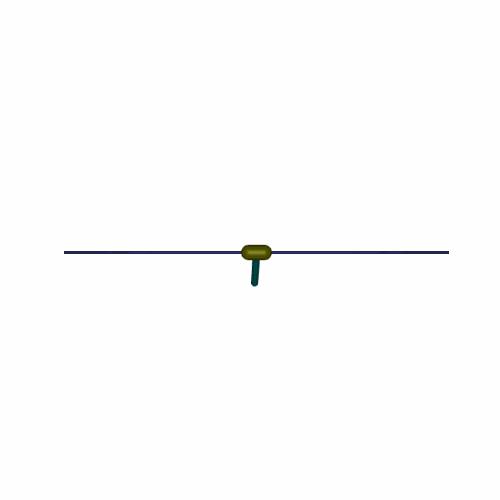

In [7]:
dynamics_model.load_state_dict(torch.load('pets_checkpoint.pth'))
dynamics_model = dynamics_model.to(DEVICE)
frames, total_reward = demo_policy(policy, environment_name=ENVIRONMENT_NAME, steps=200)
gif_path = save_frames_as_gif(frames, method_name='pets')
print('Total Reward:', total_reward)
Image(open(gif_path,'rb').read())

Congrats on finishing the MBRL portion of Assignment 2! Hopefully you enjoyed yourself. Make sure that the visualizations are showing, an eval with a reward greater than 150 is showing above, and that the `pets_policy.gif` is present in the outputs folder.

When you're done: export this notebook as an **HTML file** for final submission.